In [1]:
from pint import UnitRegistry

ureg = UnitRegistry()
ureg.define("T = 1 * particle")
ureg.define("n = 1 * particle")

SPECIFIC_ACT = 3.57e14 * ureg.Bq * ureg.g**-1
MOLAR_MASS = 6.032 / 2 * ureg.g * ureg.mol**-1
HENRY_CONSTANT = 1e19 * ureg.T * ureg.m**-3 * ureg.Pa**-1  # taken as an average value from HTM
GAS_CONSTANT = 8.314 * ureg.J * ureg.mol**-1 * ureg.K**-1

def compute_activity_rate(TBR, neutron_flux):

    T_generation_rate = TBR * neutron_flux
    T_generation_rate = T_generation_rate.to(ureg.mol * ureg.s**-1)

    activity_inrease_rate = T_generation_rate * MOLAR_MASS * SPECIFIC_ACT
    return activity_inrease_rate


def quantity_to_activity(quantity):
    return quantity * SPECIFIC_ACT * MOLAR_MASS

volume_libra = 500 * ureg.L
libra_tbr = 1.12 * ureg.T * ureg.n**-1
libra_neutron_flux = 1e10 * ureg.n * ureg.s**-1
libra_temperature = ureg.Quantity(600, ureg.degC)

volume_baby = 1 * ureg.L
baby_tbr = 0.5 * ureg.T * ureg.n**-1  # to be confirmed
baby_neutron_flux = 3e8 * ureg.n * ureg.s**-1
print(f"Activity: {compute_activity_rate(libra_tbr, libra_neutron_flux): .1e}")


Activity: 2.0e+01 becquerel / second


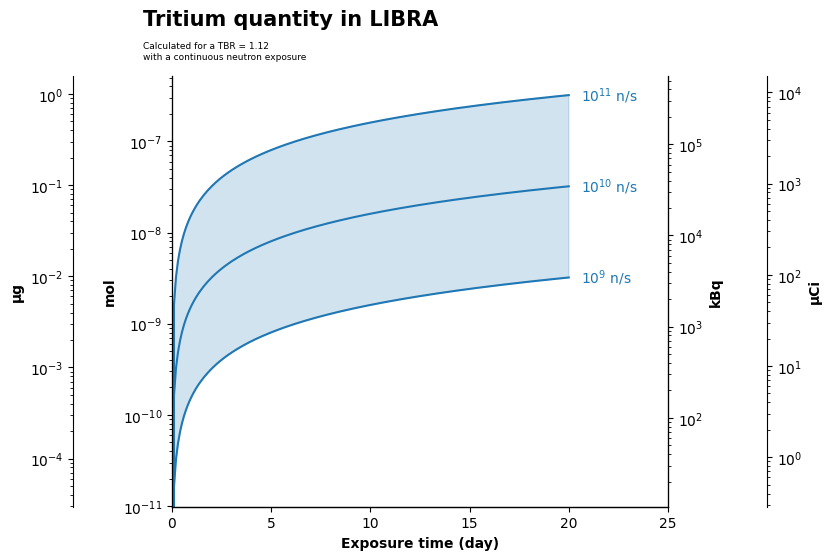

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import matplotx

plt.figure(figsize=(6.4, 5.6))


def as_si(x, ndp):
    s = "{x:0.{ndp:d}e}".format(x=x, ndp=ndp)
    m, e = s.split("e")
    val = ""
    if m != "1":
        val = r"{m:s} \times".format(m=m)
    val += r"10^{{{e:d}}}".format(e=int(e))
    return val


ureg.setup_matplotlib()

t = np.linspace(0 * ureg.days, 20 * ureg.days, num=200)
quantities = []
for neutron_flux in [1e9, 1e10, 1e11] * ureg.n * ureg.s**-1:
    quantity = t * libra_tbr * neutron_flux
    quantity = quantity.to(ureg.mol)

    quantities.append(quantity)
    plt.plot(
        t.magnitude,
        quantity.magnitude,
        label=f"${as_si(neutron_flux.magnitude, 0)}$ {neutron_flux.units: ~P}",
        color="tab:blue",
    )

plt.fill_between(t, quantities[0], quantities[-1], color="tab:blue", alpha=0.2)

plt.gcf().text(0.08, 0.97, "Tritium quantity in LIBRA", weight="bold", fontsize=15)
subtitle = [
    f"Calculated for a TBR = {libra_tbr.magnitude}",
    "with a continuous neutron exposure",
]

plt.gcf().text(0.08, 0.91, s="\n".join(subtitle), fontsize=6.5)
plt.yscale("log")
plt.xlim(left=0, right=20)  # trick to have the labels closer to the line
matplotx.line_labels(alpha=0.05)
plt.xlim(left=0, right=25)

plt.xlabel(f"Exposure time ({t.units})", weight="bold")
plt.ylabel(f"{quantity.units: ~P}", weight="bold")

ax_mol = plt.gca()

ax_ug = ax_mol.twinx()


y1, y2 = ax_mol.get_ylim() * quantity.units
y1 *= MOLAR_MASS
y2 *= MOLAR_MASS
ax_ug.set_ylim(y1.to(ureg.microgram), y2.to(ureg.microgram))
ax_ug.set_yscale("log")
ax_ug.set_ylabel(f"{ureg.microgram: ~P}", weight="bold")


ax_ug.spines["left"].set_position(("axes", -0.2))

ax_ug.spines["left"].set_visible(True)
ax_ug.yaxis.set_label_position("left")
ax_ug.yaxis.set_ticks_position("left")

# kBq
ax_kbq = ax_mol.twinx()
y1, y2 = quantity_to_activity(ax_mol.get_ylim() * quantity.units)
ax_kbq.set_ylim(y1.to(ureg.kBq), y2.to(ureg.kBq))
ax_kbq.set_yscale("log")
ax_kbq.set_ylabel(f"{ureg.kBq: ~P}", weight="bold")

# uCi
ax_uci = ax_mol.twinx()
y1, y2 = ax_kbq.get_ylim() * ureg.kBq
ax_uci.set_ylim(y1.to(ureg.microcurie), y2.to(ureg.microcurie))
ax_uci.set_yscale("log")
ax_uci.set_ylabel(f"{ureg.microcurie: ~P}", weight="bold")

ax_uci.spines["right"].set_position(("axes", +1.2))

ax_uci.spines["right"].set_visible(True)
ax_uci.yaxis.set_label_position("right")
ax_uci.yaxis.set_ticks_position("right")

for ax in [ax_mol, ax_ug, ax_kbq, ax_uci]:
    ax.figure.canvas.draw()
    ax.spines.top.set_visible(False)

plt.savefig("libra_activity.pdf", bbox_inches="tight")
plt.savefig("libra_activity.png", bbox_inches="tight")
plt.savefig("libra_activity.svg", bbox_inches="tight")
plt.show()


In [3]:
tyne_1000_cc_ion_chamber = (
    1 * ureg.microcurie * ureg.m**-3
)  # http://www.tyne-engineering.com/1000%20cc%20Ion%20Chamber.html
tyne_10_cc_ion_chamber = (
    100 * ureg.microcurie * ureg.m**-3
)  # http://www.tyne-engineering.com/10%20cc%20Ion%20Chamber.html
wilma_60min_count_time = (
    81.4 * ureg.Bq * ureg.L**-1
)  # https://lablogic.com/radiation-safety/instruments/wilma#features
wilma_120min_count_time = (
    55.5 * ureg.Bq * ureg.L**-1
)  # https://lablogic.com/radiation-safety/instruments/wilma#features


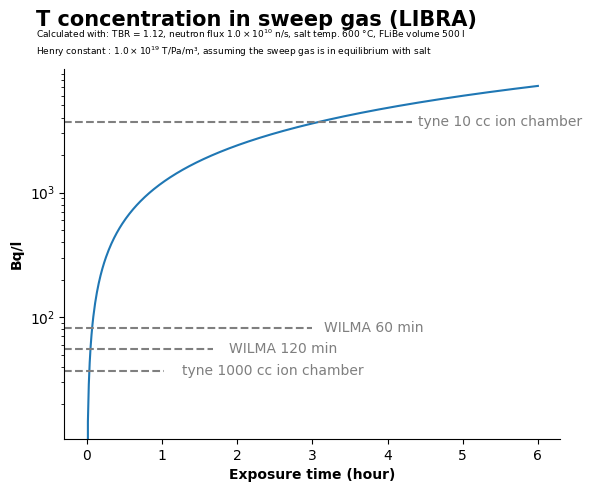

In [6]:
def salt_to_gas_concentration(salt_conc):
    # Henry's law c = K_H * P
    gas_pressure = salt_conc/HENRY_CONSTANT
    
    # PV = nRT thus P = cRT
    gas_concentration = gas_pressure/GAS_CONSTANT/(libra_temperature.to(ureg.K))

    return gas_concentration

t = np.linspace(0, 6, num=500) * ureg.hour
quantity = t * libra_tbr * libra_neutron_flux

salt_concentration = quantity/ volume_libra
gas_concentration = salt_to_gas_concentration(salt_concentration)
gas_activity = quantity_to_activity(gas_concentration)
gas_activity = gas_activity.to(ureg.Bq * ureg.liter ** -1)

plt.figure()

plt.plot(t, gas_activity)
plt.gcf().text(0.08, 0.97, "T concentration in sweep gas (LIBRA)", weight="bold", fontsize=15)
subtitle = [
    f"Calculated with: TBR = {libra_tbr.magnitude}, neutron flux ${as_si(libra_neutron_flux.magnitude, 1)}$ {libra_neutron_flux.units: ~P}, salt temp. {libra_temperature: ~P}, FLiBe volume {volume_libra: ~P}",
    f"Henry constant : ${as_si(HENRY_CONSTANT.magnitude, 1)}$ {HENRY_CONSTANT.units: ~P}, assuming the sweep gas is in equilibrium with salt",
]

plt.gcf().text(0.08, 0.91, s="\n".join(subtitle), fontsize=6.5)

l1 = plt.axhline(
    tyne_1000_cc_ion_chamber,
    xmax=0.2,
    linestyle="dashed",
    color="tab:grey",
    label="tyne 1000 cc ion chamber",
)
l2 = plt.axhline(
    tyne_10_cc_ion_chamber,
    xmax=0.7,
    linestyle="dashed",
    color="tab:grey",
    label="tyne 10 cc ion chamber",
)
l3 = plt.axhline(
    wilma_60min_count_time,
    xmax=0.5,
    linestyle="dashed",
    color="tab:grey",
    label="WILMA 60 min",
)
l4 = plt.axhline(
    wilma_120min_count_time,
    xmax=0.3,
    linestyle="dashed",
    color="tab:grey",
    label="WILMA 120 min",
)

for l in [l1, l2, l3, l4]:
    plt.annotate(
        l.get_label(),
        xy=(l.get_xdata()[1] * plt.gca().get_xlim()[-1], l.get_ydata()[1]),
        va="center",
        color=l.get_color(),
    )

plt.yscale("log")
plt.ylabel(
    f"{plt.gca().get_lines()[0].get_ydata().units: ~P}", weight="bold"
)
plt.xlabel(f"Exposure time ({t.units})", weight="bold")
plt.gca().spines.top.set_visible(False)
plt.gca().spines.right.set_visible(False)
plt.show()

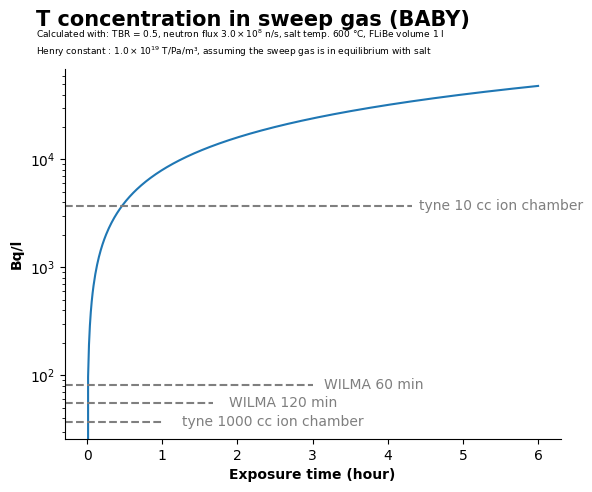

In [5]:
t = np.linspace(0, 6, num=500) * ureg.hour
quantity = t * baby_tbr * baby_neutron_flux

salt_concentration = quantity/ volume_baby
gas_concentration = salt_to_gas_concentration(salt_concentration)
gas_activity = quantity_to_activity(gas_concentration)
gas_activity = gas_activity.to(ureg.Bq * ureg.liter ** -1)

plt.figure()

plt.plot(t, gas_activity)
plt.gcf().text(0.08, 0.97, "T concentration in sweep gas (BABY)", weight="bold", fontsize=15)
subtitle = [
    f"Calculated with: TBR = {baby_tbr.magnitude}, neutron flux ${as_si(baby_neutron_flux.magnitude, 1)}$ {baby_neutron_flux.units: ~P}, salt temp. {libra_temperature: ~P}, FLiBe volume {volume_baby: ~P}",
    f"Henry constant : ${as_si(HENRY_CONSTANT.magnitude, 1)}$ {HENRY_CONSTANT.units: ~P}, assuming the sweep gas is in equilibrium with salt",
]

plt.gcf().text(0.08, 0.91, s="\n".join(subtitle), fontsize=6.5)

l1 = plt.axhline(
    tyne_1000_cc_ion_chamber,
    xmax=0.2,
    linestyle="dashed",
    color="tab:grey",
    label="tyne 1000 cc ion chamber",
)
l2 = plt.axhline(
    tyne_10_cc_ion_chamber,
    xmax=0.7,
    linestyle="dashed",
    color="tab:grey",
    label="tyne 10 cc ion chamber",
)
l3 = plt.axhline(
    wilma_60min_count_time,
    xmax=0.5,
    linestyle="dashed",
    color="tab:grey",
    label="WILMA 60 min",
)
l4 = plt.axhline(
    wilma_120min_count_time,
    xmax=0.3,
    linestyle="dashed",
    color="tab:grey",
    label="WILMA 120 min",
)

for l in [l1, l2, l3, l4]:
    plt.annotate(
        l.get_label(),
        xy=(l.get_xdata()[1] * plt.gca().get_xlim()[-1], l.get_ydata()[1]),
        va="center",
        color=l.get_color(),
    )

plt.yscale("log")
plt.ylabel(
    f"{plt.gca().get_lines()[0].get_ydata().units: ~P}", weight="bold"
)
plt.xlabel(f"Exposure time ({t.units})", weight="bold")
plt.gca().spines.top.set_visible(False)
plt.gca().spines.right.set_visible(False)
plt.show()